In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from nd2reader import ND2Reader
import tifffile
import glob
import bg_space as bg
import pandas as pd
import time

In [2]:
def nd2_to_tif(nd2_file, raw_tif_file):
    with ND2Reader(nd2_file) as imaging_series:
        umperpix = imaging_series.metadata['pixel_microns']
        imaging_series_arr = np.array([i for i in imaging_series])
        imaging_series_8bit_arr = cv2.convertScaleAbs(imaging_series_arr, alpha=0.07)
        imaging_series_mapped_arr = bg.map_stack_to('ilp','ial', imaging_series_8bit_arr) ##refer to bg-space AnatomicalSpace
        tifffile.imwrite(raw_tif_file, imaging_series_mapped_arr, imagej=True, resolution=(1/umperpix, 1/umperpix), metadata = imaging_series.metadata)
#         tifffile.imwrite(raw_tif_file, imaging_series_mapped_arr, imagej=True)


def nd2_to_tif_zscan(nd2_file, raw_tif_file):

    with ND2Reader(nd2_file) as imaging_series:
        umperpix = imaging_series.metadata['pixel_microns']
        imaging_series_arr = np.array([i for i in imaging_series])
        imaging_series_8bit_arr = cv2.convertScaleAbs(imaging_series_arr, alpha=0.07)
        imaging_series_mapped_arr = bg.map_stack_to('ilp','sal', imaging_series_8bit_arr) ##refer to bg-space AnatomicalSpace
        tifffile.imwrite(raw_tif_file, imaging_series_mapped_arr, imagej=True, resolution=(1/umperpix, 1/umperpix), metadata = imaging_series.metadata)
#         tifffile.imwrite(raw_tif_file, imaging_series_mapped_arr, imagej=True)


def tif_concat(raw_tif_file_list, combined_tif_path):

    combined_tif = []
    for raw_tif in raw_tif_file_list:
        im = tifffile.imread(raw_tif)
        im_8bit = cv2.convertScaleAbs(im, alpha=0.07)
        combined_tif.append(im_8bit)
#     print (combined_tif)
    combined_tif = np.concatenate(combined_tif)
    print (combined_tif.shape)
    tifffile.imwrite(combined_tif_path, combined_tif, imagej=True, resolution=(1/umperpix, 1/umperpix))

def create_directory(path):
    if os.path.exists(path):
        return False
    os.makedirs(path)
    return True

In [3]:
import cv2 as cv
from PIL import Image

2D Registration
Input: directory where you put your planes and zstack;
Modify the path and fish name before you run the code.

In [4]:
# Input Part
main_dir = "/media/semmelhacklab/David_Behavior_Experiment/testfish/2023-07-06_F1_lowintensity_test"
width = 512

##########################
### Rember to check whether resize or not work better
# resize = int(509.12/339.41*width)
resize = int(512/512*width)
# resize = int(width)
##########################

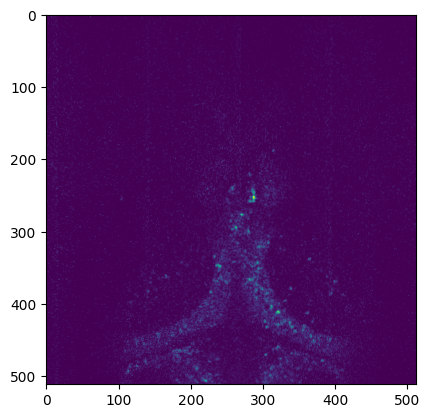

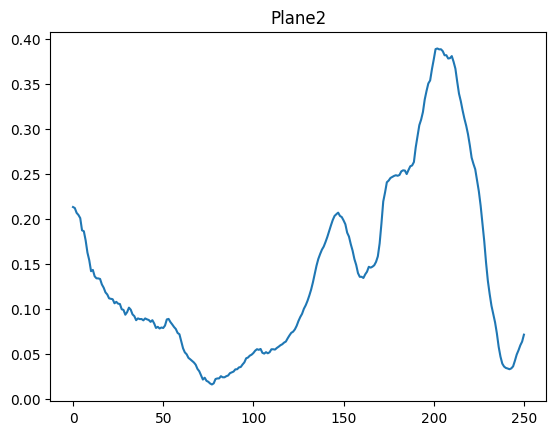

203
(0, 0)


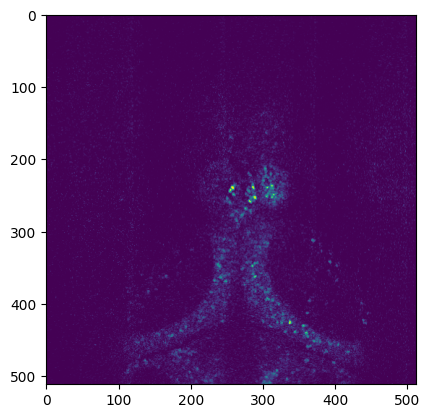

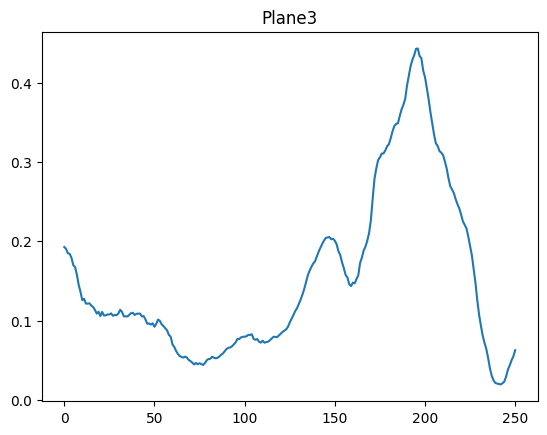

197
(0, 0)


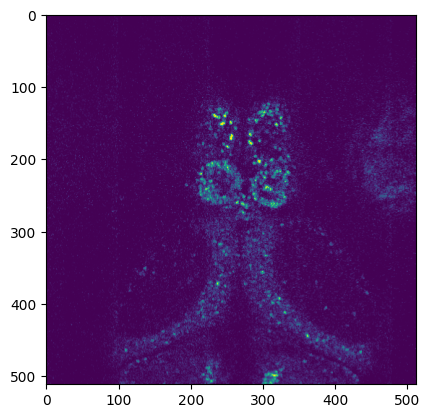

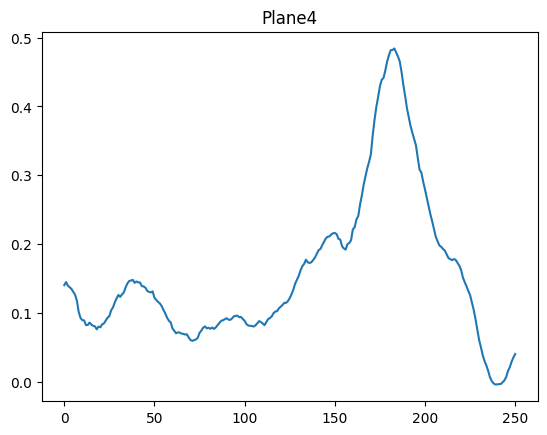

184
(0, 0)


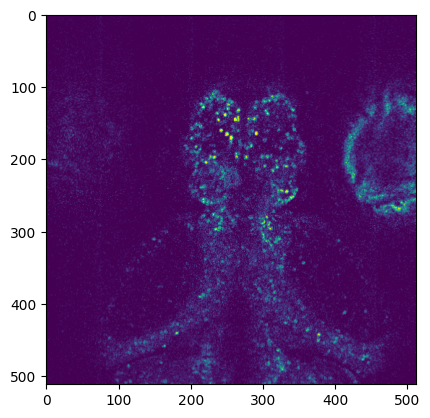

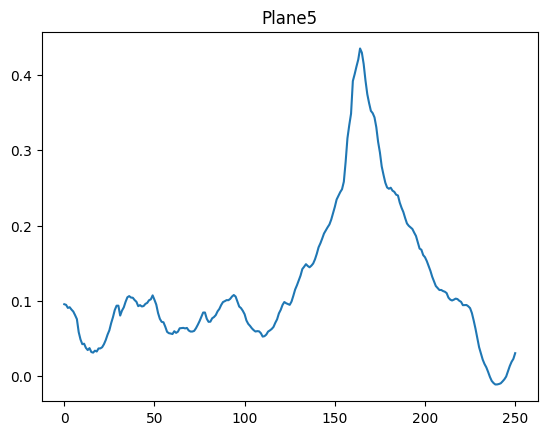

165
(0, 0)


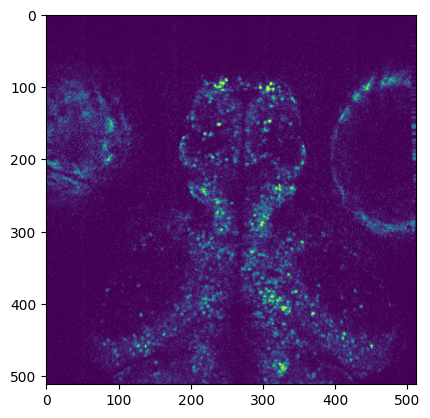

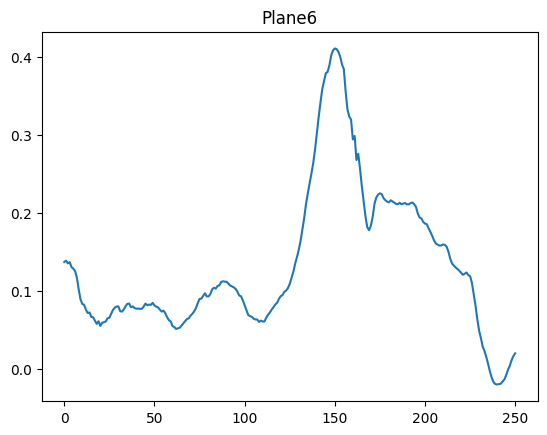

151
(0, 0)


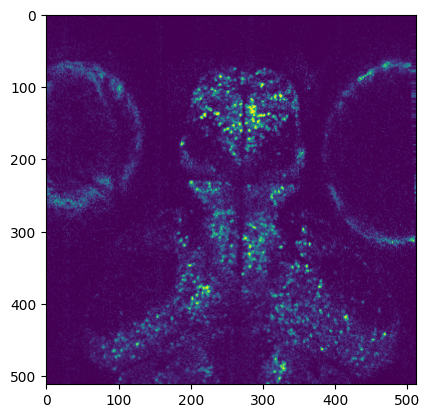

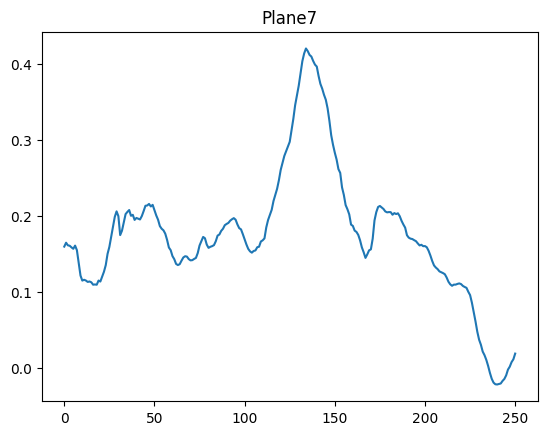

135
(0, 0)


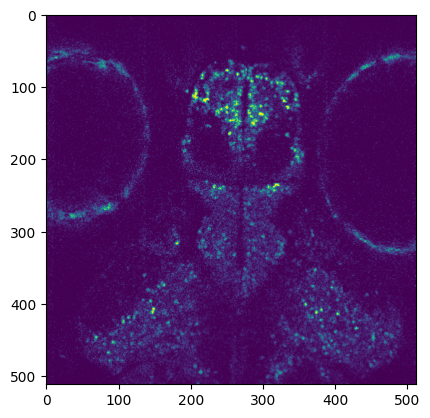

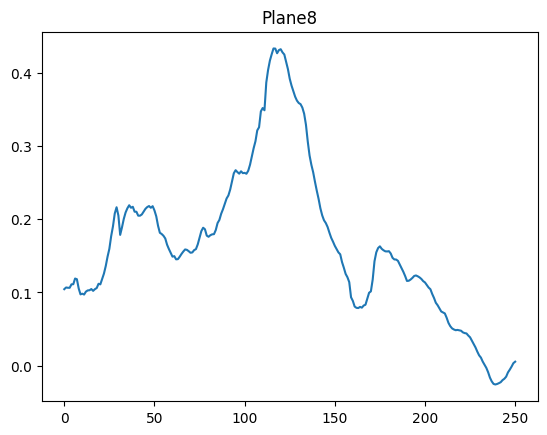

117
(0, 0)


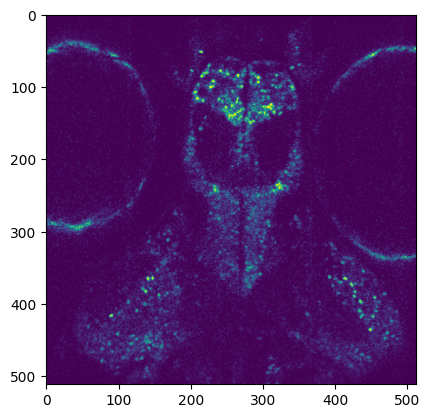

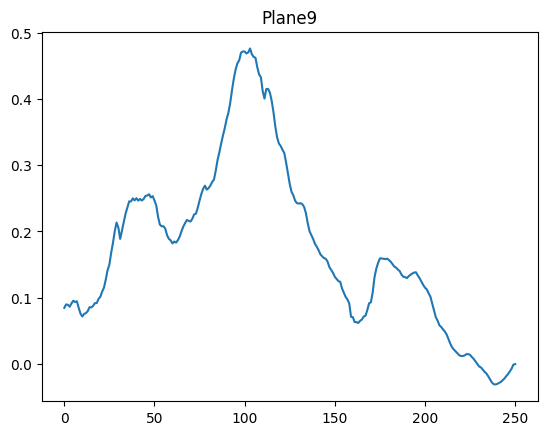

104
(0, 0)


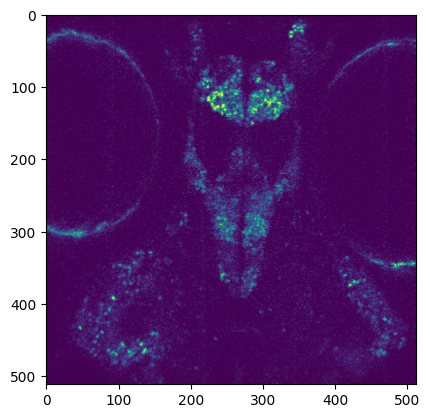

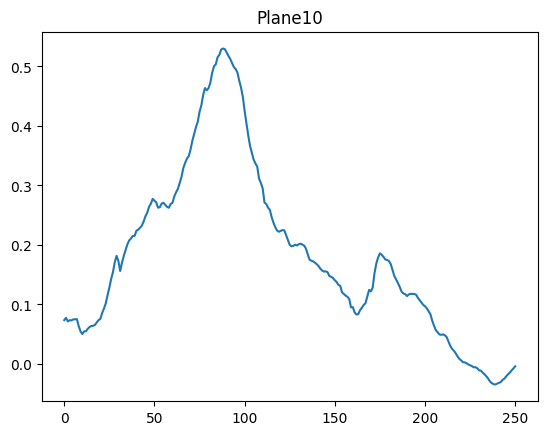

89
(0, 0)


In [5]:
for p_i in range(2,11):
    directory_2d = main_dir+'/Plane'+str(p_i)
    create_directory(directory_2d)
    registered_dir=main_dir+'/Plane'+str(p_i)+'.tif'
    registered=tifffile.imread(registered_dir)
    
    avg_combined_reg_8bit = cv.convertScaleAbs(registered, alpha=0.7)
    tifffile.imwrite(directory_2d+'/'+'Plane'+str(p_i)+'_avg_combined_reg.tif', avg_combined_reg_8bit)
        
    temp_image = Image.open(directory_2d+'/'+'Plane'+str(p_i)+'_avg_combined_reg.tif')
    resized_image = temp_image.resize((resize, resize), Image.Resampling.LANCZOS)
    resized_image.save(directory_2d+'/'+'Plane'+str(p_i)+'_avg_combined_reg_resized.tif')
        
    img2 = tifffile.imread(main_dir+'/F1_zscan.tif')
    template =  cv.imread(directory_2d+'/'+'Plane'+str(p_i)+'_avg_combined_reg_resized.tif',0)
    plt.imshow(template)
    plt.show()
    w, h = template.shape[::-1]
    method = cv.TM_CCOEFF_NORMED
    # top_left = np.array(shape=(img2.shape[0],2))
    corr_score= []
    top_left_list = []
    for i in range(0,img2.shape[0]):
        img = img2[i].copy()
        res = cv.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        top_left = max_loc
        corr_score.append(max_val)
        top_left_list.append(top_left)

    plt.plot(corr_score)
    plt.title('Plane'+str(p_i))
    plt.show()
#         preprocessing_2p 
    temp_slice_no = np.argmax(corr_score)
    #     temp_slice_no = np.argmax(corr_score[80:])+80
    print(temp_slice_no+1)
    print(top_left_list[temp_slice_no])   
    tifffile.imwrite(directory_2d+'/'+'Plane'+str(p_i)+'_zstack_slice.tif',img2[temp_slice_no,:,:])
    np.save(directory_2d+'/slice_no.npy',np.array(temp_slice_no+1))

In [6]:
for p_i in range(2,11):
    directory_2d=main_dir+'/Plane'+str(p_i)
    sh_reg2d_path=directory_2d+'/reg2d.sh'
    with open(sh_reg2d_path,'w') as f:
        s = 'directory_2d='+directory_2d+'\n'+\
            'plane=Plane'+str(p_i)+'\n'+\
            'reference=${directory_2d}/${plane}_zstack_slice.tif\n'+\
            'moving_file=${directory_2d}/${plane}_avg_combined_reg_resized.tif\n'+\
            'prefix=${directory_2d}/${plane}_2d_output_\n'+\
            'warped_file=${prefix}warped.tif\n\n\n'+\
            'antsRegistration --verbose 1 \\\n\
            --dimensionality 2 \\\n\
            --float \\\n\
            --collapse-output-transforms 1 \\\n\
            --output [$prefix,${prefix}Warped.nii.gz,${prefix}InverseWarped.nii.gz ] \\\n\
            --interpolation Linear \\\n\
            --winsorize-image-intensities [ 0.005,0.995 ] \\\n\
            --initial-moving-transform [ $reference,$moving_file,1 ] \\\n\
            --transform Rigid[ 0.1 ] \\\n\
            --metric MI[ $reference,$moving_file,1,32,Regular,0.25 ] \\\n\
            --convergence [ 1000x500x250x0,1e-8,15 ] \\\n\
            --shrink-factors 12x8x4x2 \\\n\
            --smoothing-sigmas 4x3x2x1vox \\\n\
            --transform Affine[ 0.1 ] \\\n\
            --metric MI[ $reference,$moving_file,1,32,Regular,0.25 ] \\\n\
            --convergence [ 1000x500x250x0,1e-8,15 ] \\\n\
            --shrink-factors 12x8x4x2 \\\n\
            --smoothing-sigmas 4x3x2x1vox\n\n\n'+\
            'antsApplyTransforms --verbose 1 \\\n\
            --dimensionality 2 \\\n\
            --float \\\n\
            --interpolation WelchWindowedSinc \\\n\
            --input $moving_file \\\n\
            --reference-image $reference \\\n\
            --output $warped_file \\\n\
            --transform ${prefix}0GenericAffine.mat'
        f.write(s)
                # run the shell script above
    command="sh "+sh_reg2d_path
    os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 5\" '")
    time.sleep(10)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line t

3D Registration
Please convert zstack's format to nrrd. 
Modify path and fish name before you run the code.

In [12]:
# Input Part
main_dir = "/media/semmelhacklab/David_Behavior_Experiment/testfish/2023-07-06_F1_lowintensity_test"
reference_path = "/media/semmelhacklab/David_Behavior_Experiment/testfish/HSA.nrrd"

In [13]:
directory_3d = main_dir
sh_reg3d_path = directory_3d+'/reg3d.sh'
# write 3d registration shell script for each fish
with open(sh_reg3d_path,'w') as f:
    s = 'reference='+reference_path+'\n'+\
        'directory_3d='+directory_3d+'\n'+\
        'moving_file=${directory_3d}/F1_zscan.nrrd\n'+\
        'prefix=${directory_3d}/reg3d\n'+\
        'warped_file=${prefix}zscan_wrapped.nrrd\n\n\n'+\
        'antsRegistration --verbose 1 \\\n\
        --dimensionality 3 \\\n\
        --float \\\n\
        --collapse-output-transforms 1 \\\n\
        --output [$prefix,${prefix}Warped.nii.gz,${prefix}InverseWarped.nii.gz ] \\\n\
        --interpolation Linear \\\n\
        --winsorize-image-intensities [ 0.005,0.995 ] \\\n\
        --initial-moving-transform [ $reference,$moving_file,1 ] \\\n\
        --transform Rigid[ 0.1 ] \\\n\
        --metric MI[ $reference,$moving_file,1,32,Regular,0.25 ] \\\n\
        --convergence [ 1000x500x250x0,1e-6,10 ] \\\n\
        --shrink-factors 12x8x4x2 \\\n\
        --smoothing-sigmas 4x3x2x1vox \\\n\
        --transform Affine[ 0.1 ] \\\n\
        --metric MI[ $reference,$moving_file,1,32,Regular,0.25 ] \\\n\
        --convergence [ 1000x500x250x0,1e-6,10 ] \\\n\
        --shrink-factors 12x8x4x2 \\\n\
        --smoothing-sigmas 4x3x2x1vox \\\n\
        --transform SyN[ 0.1,3,0 ] \\\n\
        --metric MI[ $reference,$moving_file,1,32] \\\n\
        --convergence [ 100x100x70x50x0,1e-6,10 ] \\\n\
        --shrink-factors 10x6x4x2x1 \\\n\
        --smoothing-sigmas 5x3x2x1x0vox\n\n\n'+\
        'antsApplyTransforms --verbose 1 \\\n\
        --dimensionality 3 \\\n\
        --float \\\n\
        --interpolation WelchWindowedSinc \\\n\
        --input $moving_file \\\n\
        --reference-image $reference \\\n\
        --output $warped_file \\\n\
        --transform ${prefix}1Warp.nii.gz \\\n\
        --transform ${prefix}0GenericAffine.mat'
    f.write(s)

# run the shell script above
command="sh "+sh_reg3d_path
os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 30\" '")
time.sleep(1500)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.


Apply Transformation

In [69]:
# Input part
main_dir = "/media/semmelhacklab/Suzaku_passport/new_roi1107/2023-07-05_F2_highintensity"
##########################
### Rember to check whether resize or not work better
resize_ratio = 512/512
##########################

In [70]:
for p_i in range(2,11):
    directory_2d=main_dir+'/Plane'+str(p_i)
    slice_no=np.load(directory_2d+'/slice_no.npy')
#     path_cell_info=main_dir+'/Plane'+str(p_i)+'_roi_coordinates.csv'
    path_cell_info=main_dir+'/Plane'+str(p_i)+'_roi_coordinates_0.5.csv'
    df_cell_info = pd.read_csv(path_cell_info)
    df_coor = pd.DataFrame(columns = ['x','y','z','t','label'])
    df_coor.x = df_cell_info.x*resize_ratio
    df_coor.y = df_cell_info.y*resize_ratio
    df_coor.z = slice_no
    df_coor.t = 0
    df_coor.label = df_cell_info.label
    path_toreg = directory_2d+'/'+'Plane'+str(p_i)+'_coordinates.csv'
    df_coor.to_csv(path_toreg,index=False)           
    

In [71]:
for p_i in range(2,11):
        directory_2d=main_dir+'/Plane'+str(p_i)
        
        sh_applyreg2d_path = directory_2d+'/ApplyToROIs_reg2d.sh'
        # write 2d ApplyToROIs shell script for each plane
        with open(sh_applyreg2d_path,'w') as f:
            s = 'directory_2d='+directory_2d+'\n'+\
                'plane=Plane'+str(p_i)+'\n'+\
                'prefix2d=${directory_2d}/${plane}_2d_output_\n'+\
                'prefix_csv=${directory_2d}/${plane}_coordinates\n\n\n'+\
                'antsApplyTransformsToPoints -d 2 -i ${prefix_csv}.csv -o ${prefix_csv}_reg2d.csv -t [${prefix2d}0GenericAffine.mat,1]'
            f.write(s)
        # run the shell script above
        command="sh "+sh_applyreg2d_path
        os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 3\" '")
        time.sleep(3)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line t

In [72]:
# Input part
ratio_pixel_to_micron = 509.12/512

In [73]:
for p_i in range(2,11):
    dir_list=glob.glob(main_dir+'/Plane'+str(p_i)+'/Plane'+str(p_i)+'_coordinates_reg2d.csv')
    for temp_dir in dir_list:
        temp_reg2d_csv = pd.read_csv(temp_dir)
        temp_reg2d_csv.x = temp_reg2d_csv.x*ratio_pixel_to_micron
        temp_reg2d_csv.y = temp_reg2d_csv.y*ratio_pixel_to_micron
        temp_reg2d_csv.to_csv(temp_dir[:-4]+'_micron.csv',index=False)

In [74]:
directory_3d = main_dir
for p_i in range(2,11):
    directory_2d = main_dir+'/Plane'+str(p_i)
    sh_applyreg3d_path = directory_2d+'/ApplyToROIs_reg3d.sh'

    # write 3d ApplyToROIs shell script for each fish
    with open(sh_applyreg3d_path,'w') as f:
        s = 'directory_3d='+directory_3d+'\n'+\
            'directory_2d='+directory_2d+'\n'+\
            'plane=Plane'+str(p_i)+'\n'+\
            'prefix3d=${directory_3d}/reg3d\n'+\
            'prefix_csv=${directory_2d}/${plane}_coordinates\n\n\n'+\
            'antsApplyTransformsToPoints -d 3 -i ${prefix_csv}_reg2d_micron.csv -o ${prefix_csv}_reg3d.csv -t [${prefix3d}0GenericAffine.mat,1] -t ${prefix3d}1InverseWarp.nii.gz'
        f.write(s)

    # run the shell script above
    command="sh "+sh_applyreg3d_path
    os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 3\" '")
    time.sleep(20)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line t

In [75]:
# Input part
x_micron_to_pixel = 597/593.46
y_micron_to_pixel = 974/968.12

In [76]:
for p_i in range(2,11):
        path_csv_reg3d = main_dir+'/Plane'+str(p_i)+'/'+'Plane'+str(p_i)+'_coordinates_reg3d.csv'
        df_csv_reg3d = pd.read_csv(path_csv_reg3d)
        
#         path_cell_info = main_dir+'/Plane'+str(p_i)+'_roi_coordinates.csv'
        path_cell_info=main_dir+'/Plane'+str(p_i)+'_roi_coordinates_0.5.csv'
        df_cell_info = pd.read_csv(path_cell_info)
        
        if np.array_equiv(np.array(df_cell_info['label']),np.array(df_csv_reg3d['label'])):
            df_cell_info['reg_x'] = df_csv_reg3d['x']*x_micron_to_pixel
            df_cell_info['reg_y'] = df_csv_reg3d['y']*y_micron_to_pixel
            df_cell_info['reg_z'] = df_csv_reg3d['z']
            df_cell_info.to_csv(path_cell_info[:-4]+'_reg.csv',index = False)
        else:
            print('error when writing '+path_csv_reg3d)